# Schedule Top Consumer Profiling

This notebook deals with outlier detection, particularly from the SQL domain. This work attributes itself to detection of high consumers within a database system, particularly flagging those SQL which stand out in terms of computation time/resources required to execute.

Due to the high dimensionality of the available data points, unsupervised machine learning techniques will be applied to this problem, so as to isolate data anamolies and flag them as potential bottlenecks.

### Module Installation and Importing Libraries

In [101]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# scikit-learn
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_curve,roc_auc_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import RobustScaler
print('sklearn: %s' % sk.__version__)
# math
import math

scipy: 1.1.0
numpy: 1.15.2
pandas: 0.23.4
sklearn: 0.20.0


In [102]:
#
# Experiment Config
parallel_degree = 2
tpcds='TPCDS1' # Schema upon which to operate test
nrows=100000
y_label = ['CPU_TIME_DELTA','OPTIMIZER_COST','EXECUTIONS_DELTA','ELAPSED_TIME_DELTA']
y_label2 = ['COST','CARDINALITY','BYTES','IO_COST','TEMP_SPACE','TIME']
#
type1 = {'CPU_TIME_DELTA':'int64',
         'OPTIMIZER_COST':'int64',
         'EXECUTIONS_DELTA':'int64',
         'ELAPSED_TIME_DELTA':'int64'}
type2 = {'COST':'int64',
         'CARDINALITY':'int64',
         'BYTES':'int64',
         'IO_COST':'int64',
         'TEMP_SPACE':'int64',
         'TIME':'int64'}

### Read data from file into pandas dataframes

In [103]:
#
# Open Data
# rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_snapshot.csv'
# rep_vsql_plan_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_vsql_plan.csv'
rep_hist_snapshot_path = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds + '/rep_hist_snapshot.csv'
rep_vsql_plan_path = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds + '/rep_vsql_plan.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path,nrows=nrows,dtype=type1)
rep_vsql_plan_df = pd.read_csv(rep_vsql_plan_path,nrows=nrows,dtype=type2)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
#
rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_vsql_plan_df.columns = prettify_header(rep_vsql_plan_df.columns.values)
print(rep_hist_snapshot_df.columns)
print('------------------------------------------')
print(rep_vsql_plan_df.columns)

Index(['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'SQL_ID', 'PLAN_HASH_VALUE',
       'OPTIMIZER_COST', 'OPTIMIZER_MODE', 'OPTIMIZER_ENV_HASH_VALUE',
       'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'MODULE', 'ACTION',
       'SQL_PROFILE', 'FORCE_MATCHING_SIGNATURE', 'PARSING_SCHEMA_ID',
       'PARSING_SCHEMA_NAME', 'PARSING_USER_ID', 'FETCHES_TOTAL',
       'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA',
       'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA',
       'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL',
       'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA',
       'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL',
       'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA',
       'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL',
       'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA',
       'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWA

### Dealing with empty values

In [104]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list
#
print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_VSQL_PLAN Features ' + str(len(rep_vsql_plan_df.columns)) + ': ' + str(get_na_columns(df=rep_vsql_plan_df,headers=rep_vsql_plan_df.columns)) + "\n")
#
def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    df = df.replace('', 0)
    #df = df.replace(np.nan,0)
    return df.fillna(0)
#
# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_vsql_plan_df = fill_na(df=rep_vsql_plan_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 90: ['OPTIMIZER_COST', 'OPTIMIZER_MODE', 'OPTIMIZER_ENV_HASH_VALUE', 'LOADED_VERSIONS', 'MODULE', 'ACTION', 'SQL_PROFILE', 'PARSING_SCHEMA_ID', 'PARSING_SCHEMA_NAME', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'ELAPSED_TIME_TOTAL', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA', 'PLSEXEC_TIME_TOTAL', 'PLSEXEC_TIME_DELTA', 'JAVEXEC_TIME_TOTAL', 'JAVEXEC_TIME_DELTA', 'IO_OFFLOAD_ELIG_BYTES_TOTAL', 

### Aggregating table data

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [105]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_VSQL_PLAN: ' + str(len(rep_vsql_plan_df.columns)))
#
# Group By Values by SNAP_ID, PLAN_HASH_VALUE , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','PLAN_HASH_VALUE']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)
#
# Group By Values by PLAN_HASH_VALUE,TIMESTAMP, sum all metrics (for table REP_VSQL_PLAN)
rep_vsql_plan_df = rep_vsql_plan_df.groupby(['TIMESTAMP','SQL_ID','ID']).sum()
rep_vsql_plan_df.reset_index(inplace=True)
#
print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_VSQL_PLAN: ' + str(len(rep_vsql_plan_df.columns)) + "\n")
print(rep_hist_snapshot_df.columns)
print(rep_vsql_plan_df.columns)

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_VSQL_PLAN: 39

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_VSQL_PLAN: 22

Index(['SNAP_ID', 'PLAN_HASH_VALUE', 'DBID', 'INSTANCE_NUMBER',
       'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM',
       'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'PARSING_SCHEMA_ID',
       'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA',
       'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL',
       'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA',
       'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL',
       'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA',
       'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL',
       'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA',
       'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL',
       'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA',
       'IOWAIT_TOTAL', 'I

### Data Ordering

Sorting of datasets in order of:

* REP_HIST_SNAPSHOT - SNAP_ID
* REP_VSQL_PLAN - TIMESTAMP, SQL_ID, ID

In [106]:
rep_hist_snapshot_df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
rep_vsql_plan_df.sort_values(by=['TIMESTAMP','SQL_ID','ID'], ascending=True, inplace=True)

### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision, and rounded to 3 decimal places.

In [107]:
for col in rep_hist_snapshot_df.columns:
    try:
        rep_hist_snapshot_df[col].astype('float32',inplace=True)
    except:
        rep_hist_snapshot_df.drop(columns=col, inplace=True)
        print('Dropped column [' + col + ']')
#
print('-------------------------------------------------------------')
#
for col in rep_vsql_plan_df.columns:
    try:
        rep_vsql_plan_df[col].astype('float32',inplace=True)
    except:
        rep_vsql_plan_df.drop(columns=col, inplace=True)
        print('Dropped column [' + col + ']')
#
rep_hist_snapshot_df = np.round(rep_hist_snapshot_df, 3) # rounds to 3 dp
rep_vsql_plan_df = np.round(rep_vsql_plan_df, 3) # rounds to 3 dp

-------------------------------------------------------------
Dropped column [TIMESTAMP]
Dropped column [SQL_ID]


### Feature Selection

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [108]:
print('Before')
print(rep_hist_snapshot_df.shape)
print(rep_vsql_plan_df.shape)
#
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    #
    #print('Features which are considered flatline:\n')
    #for col in flatline_features:
    #    print(col)
    print('\nShape before dropping features: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after dropping features: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df
#
rep_hist_snapshot_df = drop_flatline_columns(df=rep_hist_snapshot_df)
rep_vsql_plan_df = drop_flatline_columns(df=rep_vsql_plan_df)
#
dropped_columns_rep_hist_snapshot = ['SNAP_ID',
                                       'PLAN_HASH_VALUE',
                                       'OPTIMIZER_ENV_HASH_VALUE',
                                       'LOADED_VERSIONS',
                                       'VERSION_COUNT',
                                       'PARSING_SCHEMA_ID',
                                       'PARSING_USER_ID']
dropped_columns_rep_vsql_plan = ['PLAN_HASH_VALUE',
                                 'ID',
                                 'OBJECT#',
                                 'PARENT_ID',
                                 'SEARCH_COLUMNS']
rep_hist_snapshot_df.drop(columns=dropped_columns_rep_hist_snapshot, inplace=True)
rep_vsql_plan_df.drop(columns=dropped_columns_rep_vsql_plan, inplace=True)
#
print('\nAfter')
print(rep_hist_snapshot_df.shape)
print(rep_vsql_plan_df.shape)

Before
(81980, 77)
(5812, 20)

Shape before dropping features: [(81980, 77)]
Shape after dropping features: [(81980, 64)]
Dropped a total [13]

Shape before dropping features: [(5812, 20)]
Shape after dropping features: [(5812, 14)]
Dropped a total [6]

After
(81980, 57)
(5812, 9)


## Guaging Outliers (REP_HIST_SNAPSHOT)

Uses the following labels and plots them, so as to showcase the presence of outliers:
* CPU_TIME_DELTA
* OPTIMIZER_COST
* EXECUTIONS_DELTA
* ELAPSED_TIME_DELTA

### Scatter Plots

The following section caters fro scatter plots between all labels as follows:

------------------------------------------
* CPU_TIME_DELTA vs OPTIMIZER_COST
* CPU_TIME_DELTA vs EXECUTIONS_DELTA
* CPU_TIME_DELTA vs ELAPSED_TIME_DELTA
------------------------------------------
* OPTIMIZER_COST vs CPU_TIME_DELTA
* OPTIMIZER_COST vs EXECUTIONS_DELTA
* OPTIMIZER_COST vs ELAPSED_TIME_DELTA
------------------------------------------
* EXECUTIONS_DELTA vs CPU_TIME_DELTA
* EXECUTIONS_DELTA vs OPTIMIZER_COST
* EXECUTIONS_DELTA vs ELAPSED_TIME_DELTA
------------------------------------------
* ELAPSED_TIME_DELTA vs CPU_TIME_DELTA
* ELAPSED_TIME_DELTA vs OPTIMIZER_COST
* ELAPSED_TIME_DELTA vs EXECUTIONS_DELTA

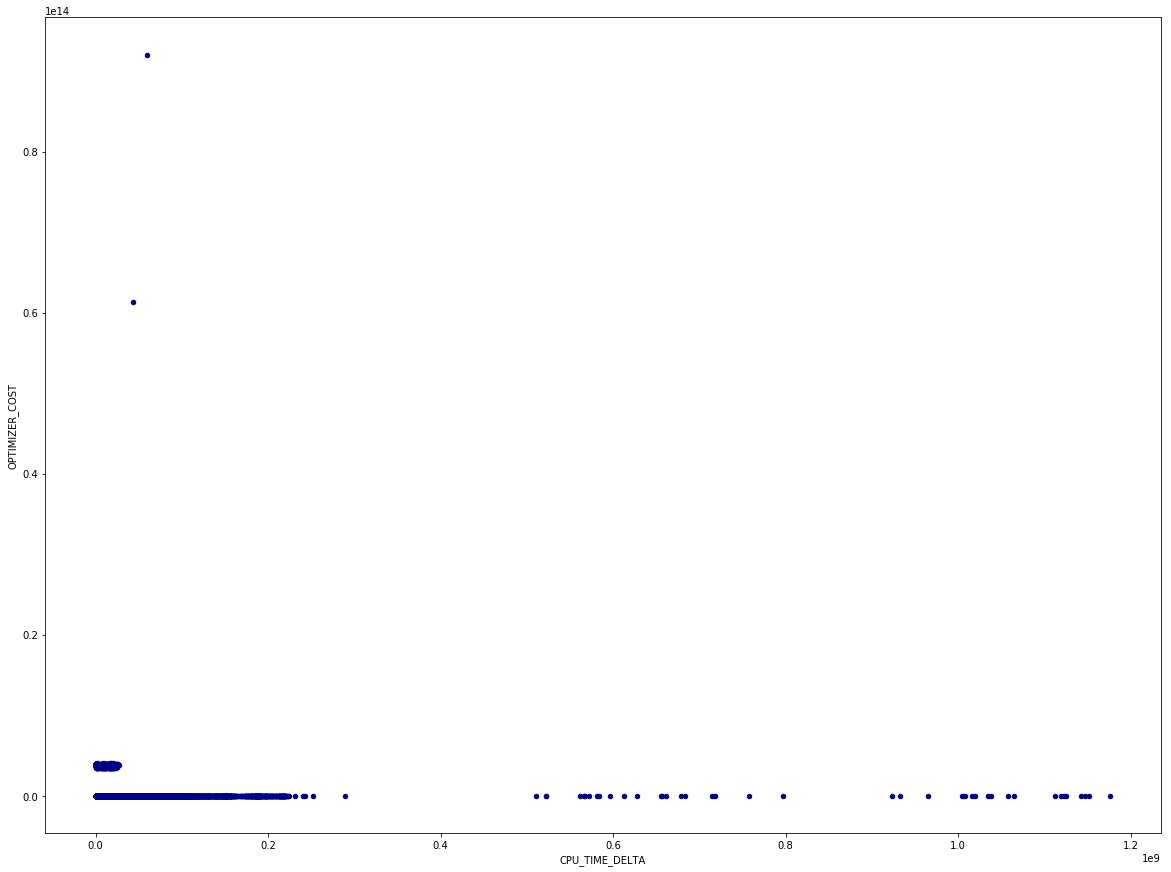

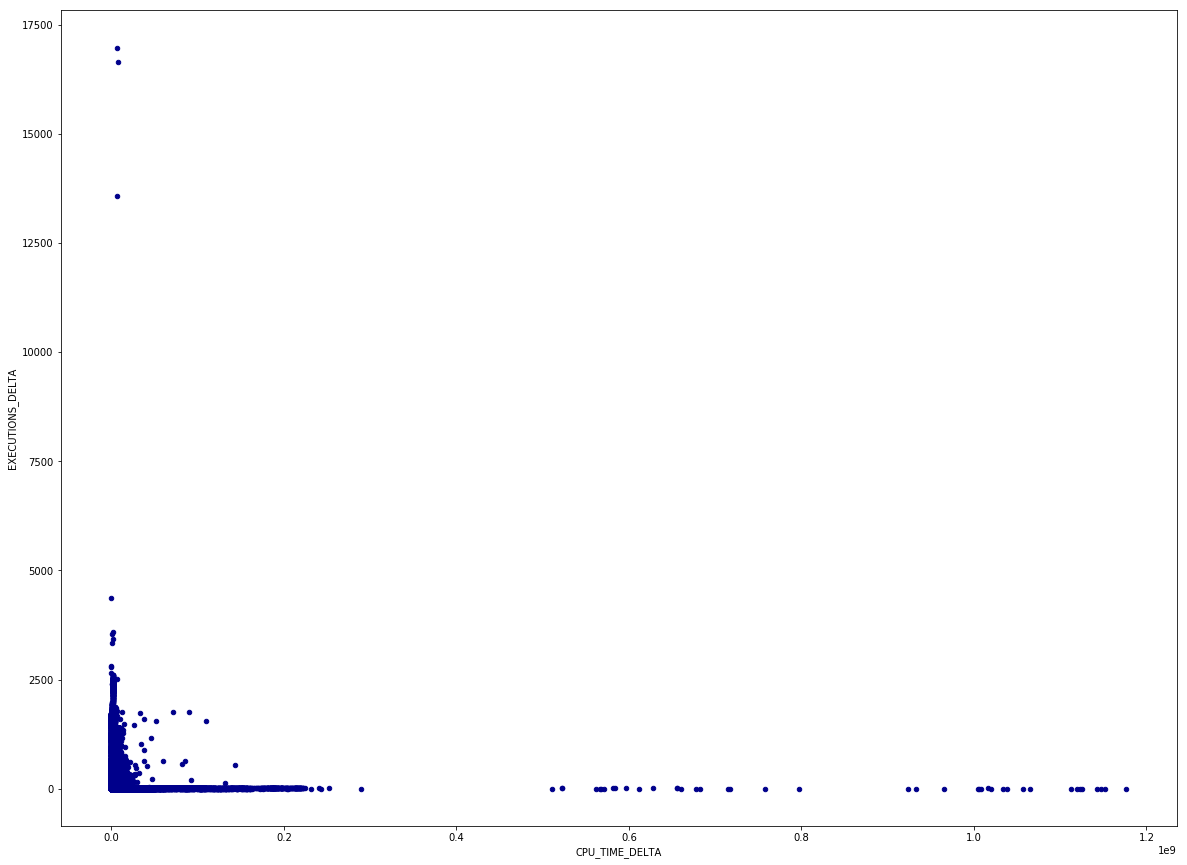

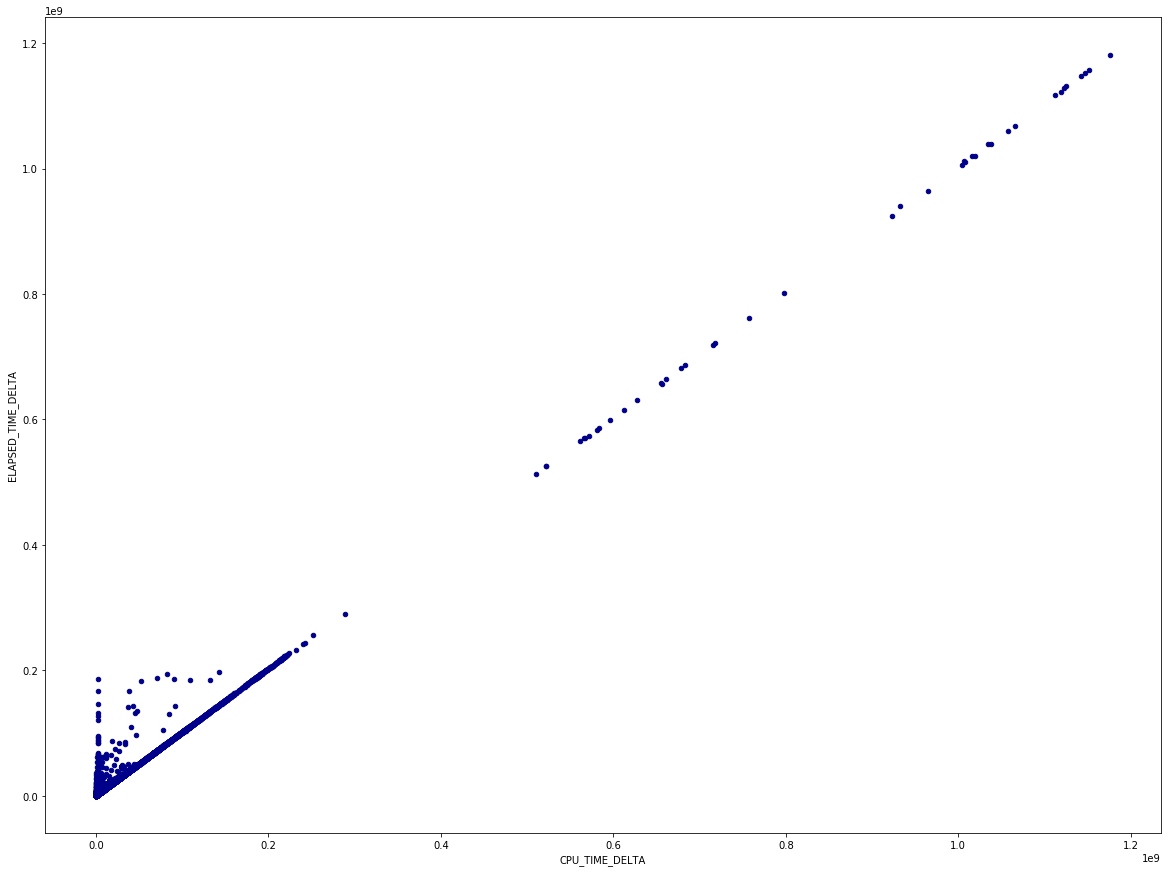

--------------------------------------------------------


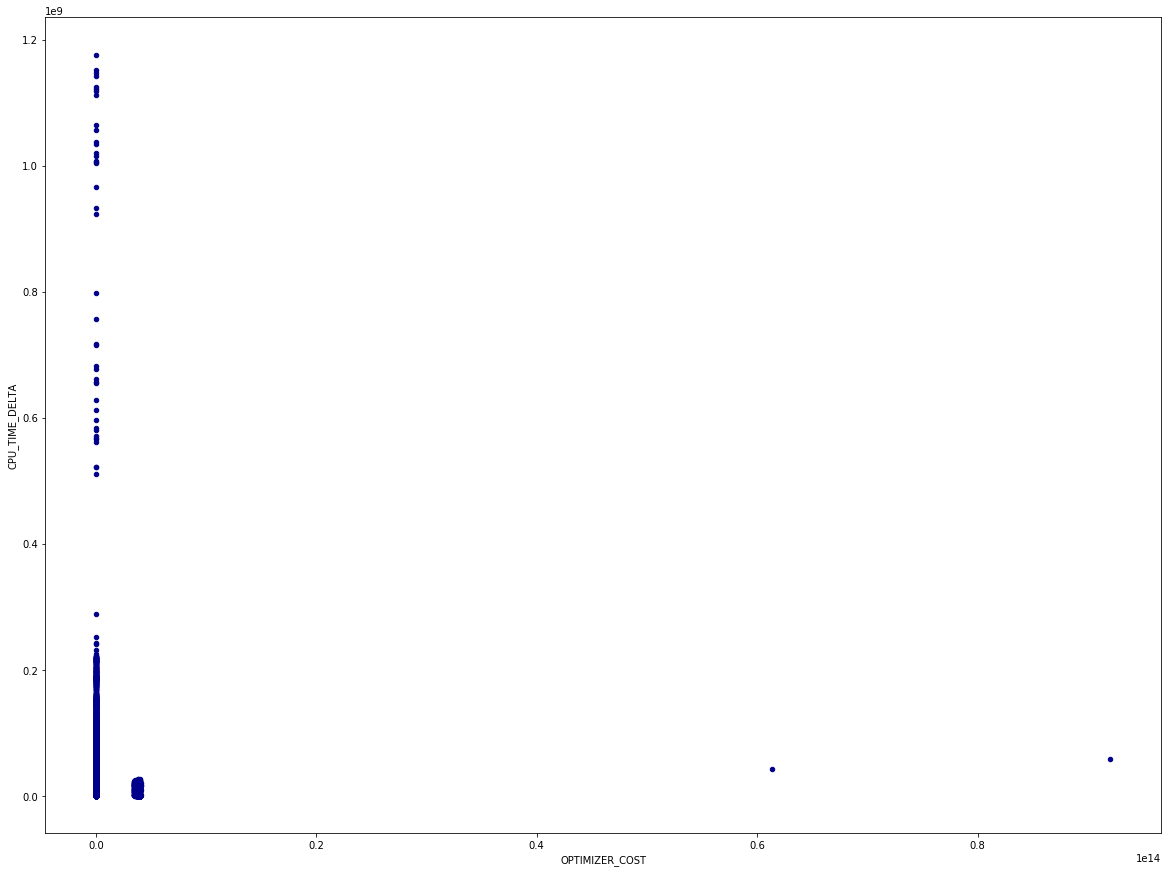

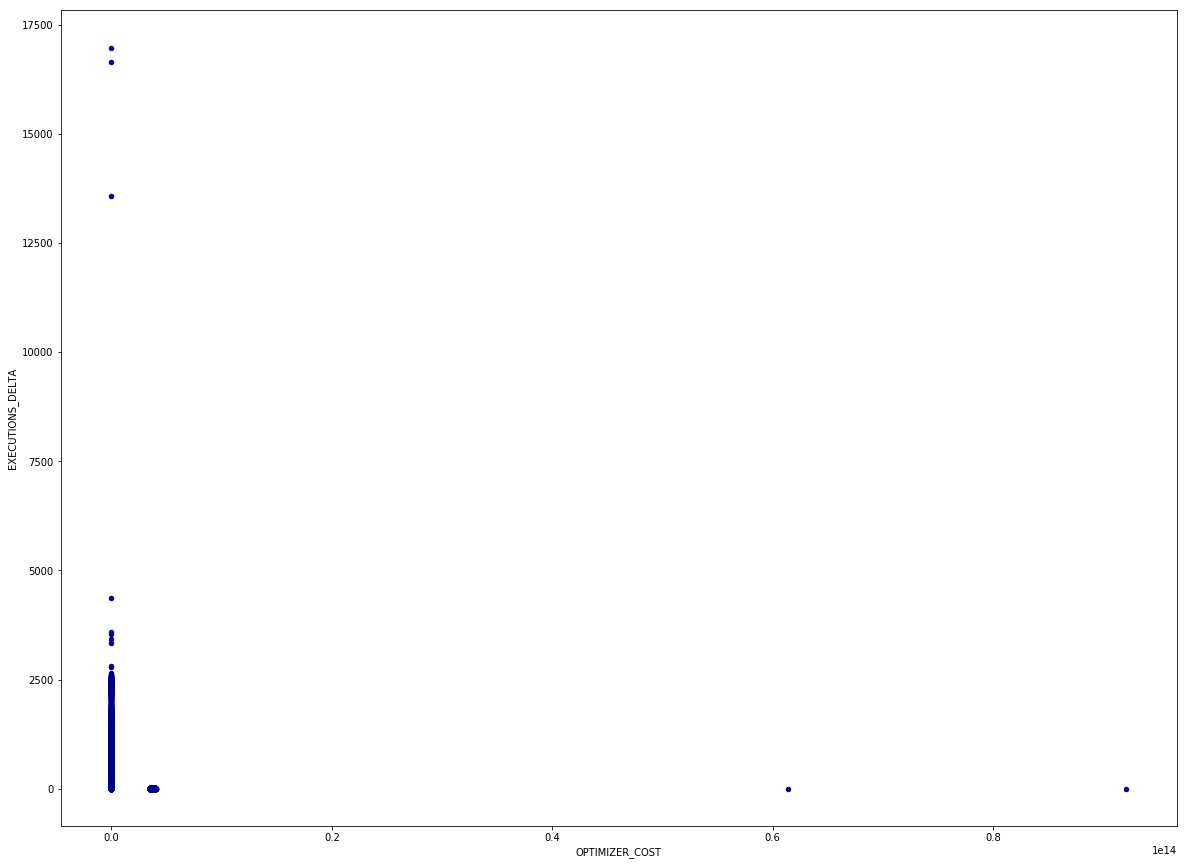

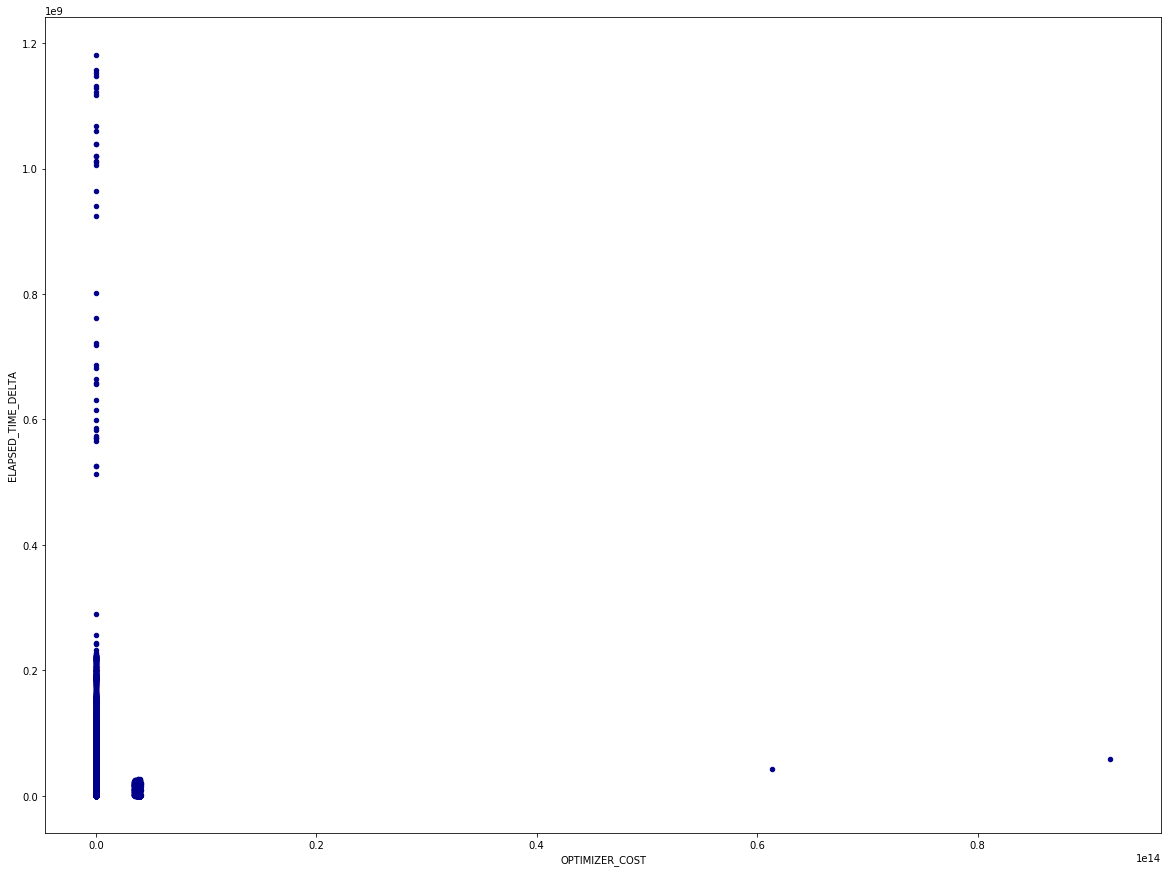

--------------------------------------------------------


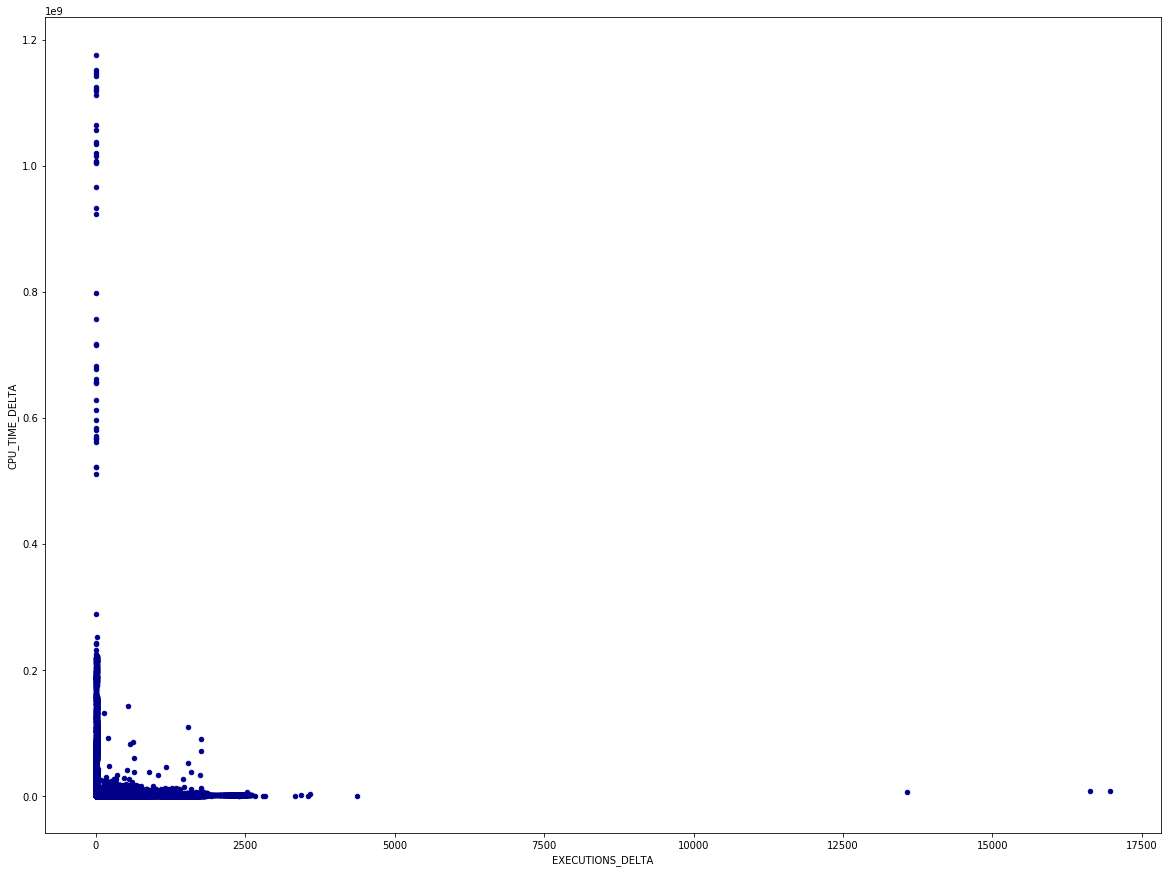

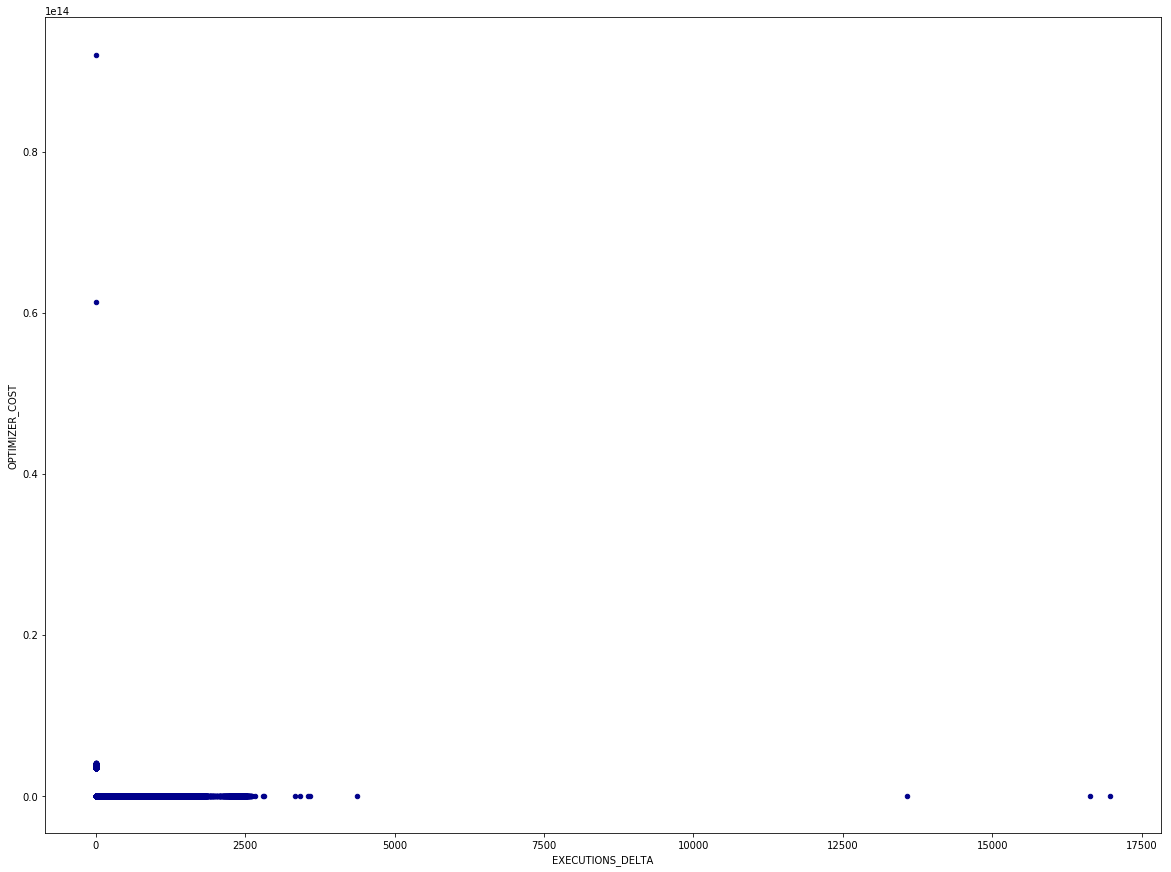

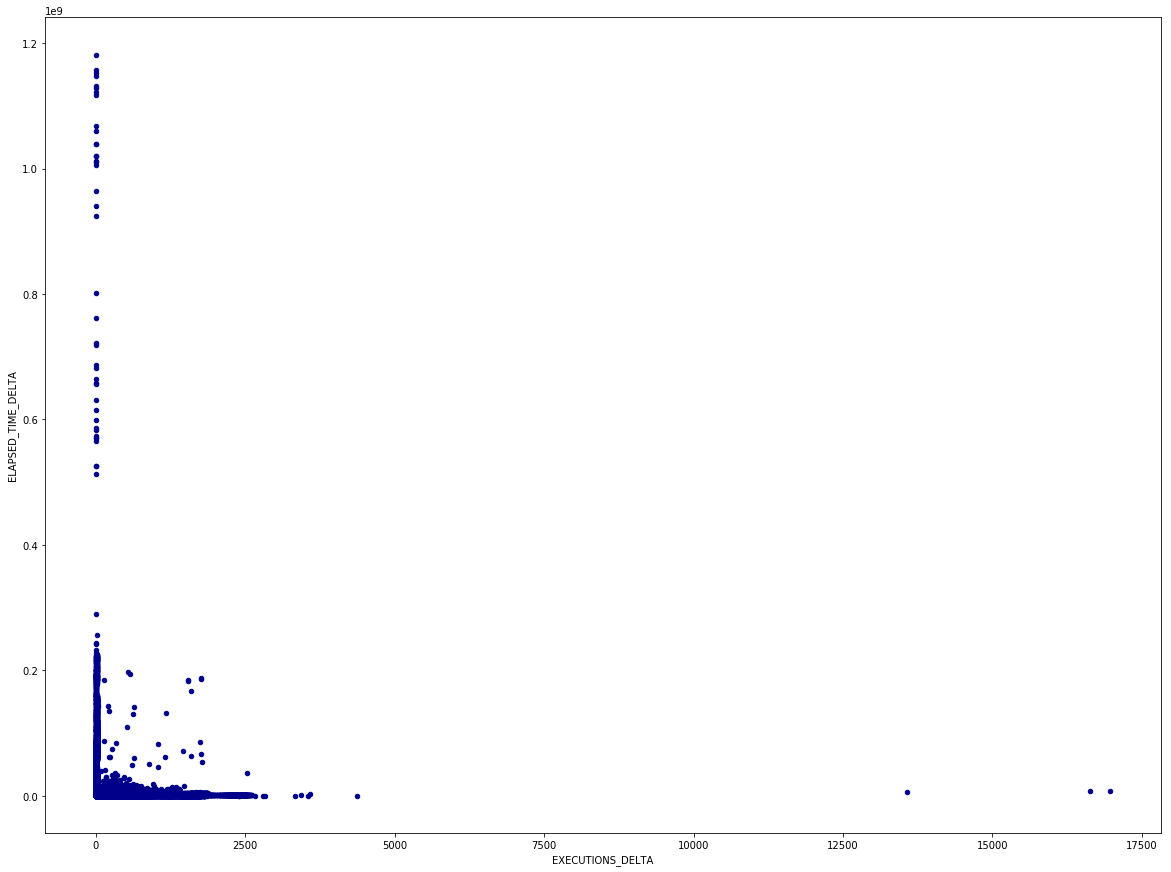

--------------------------------------------------------


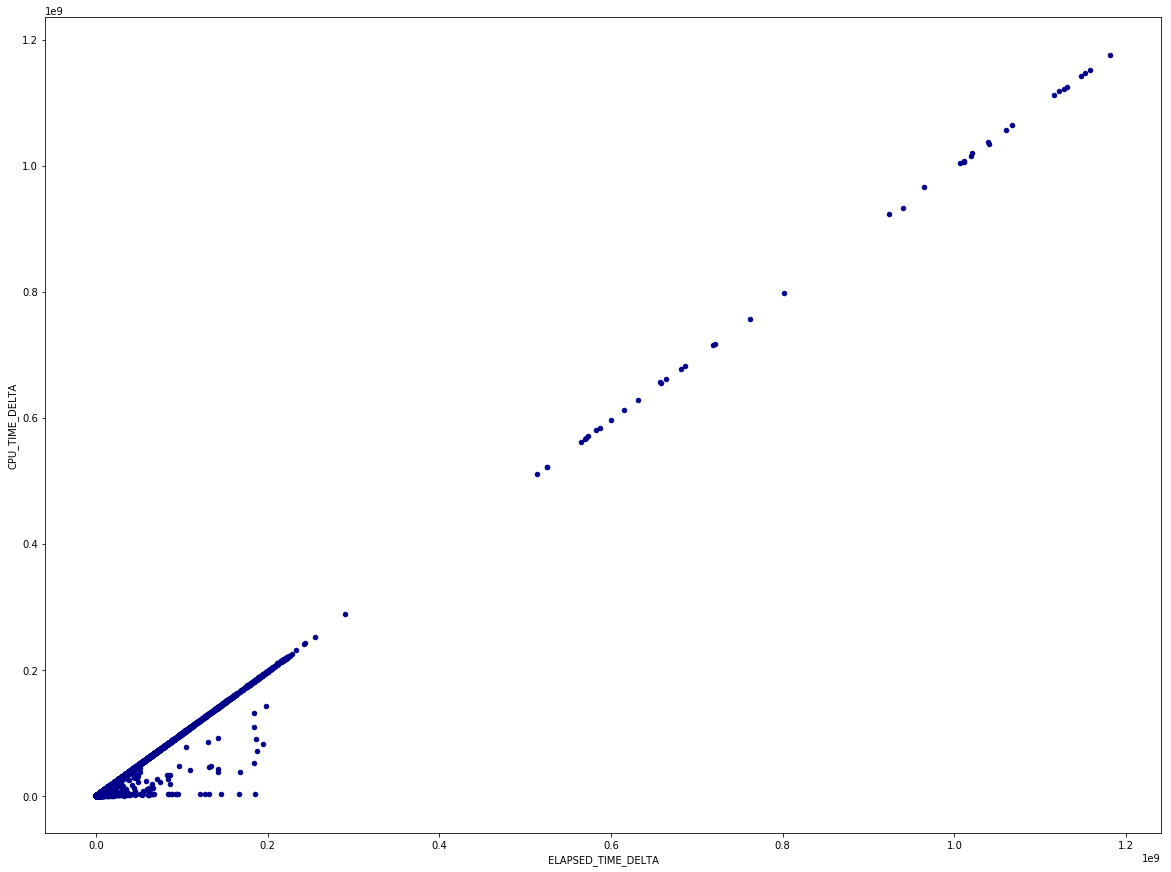

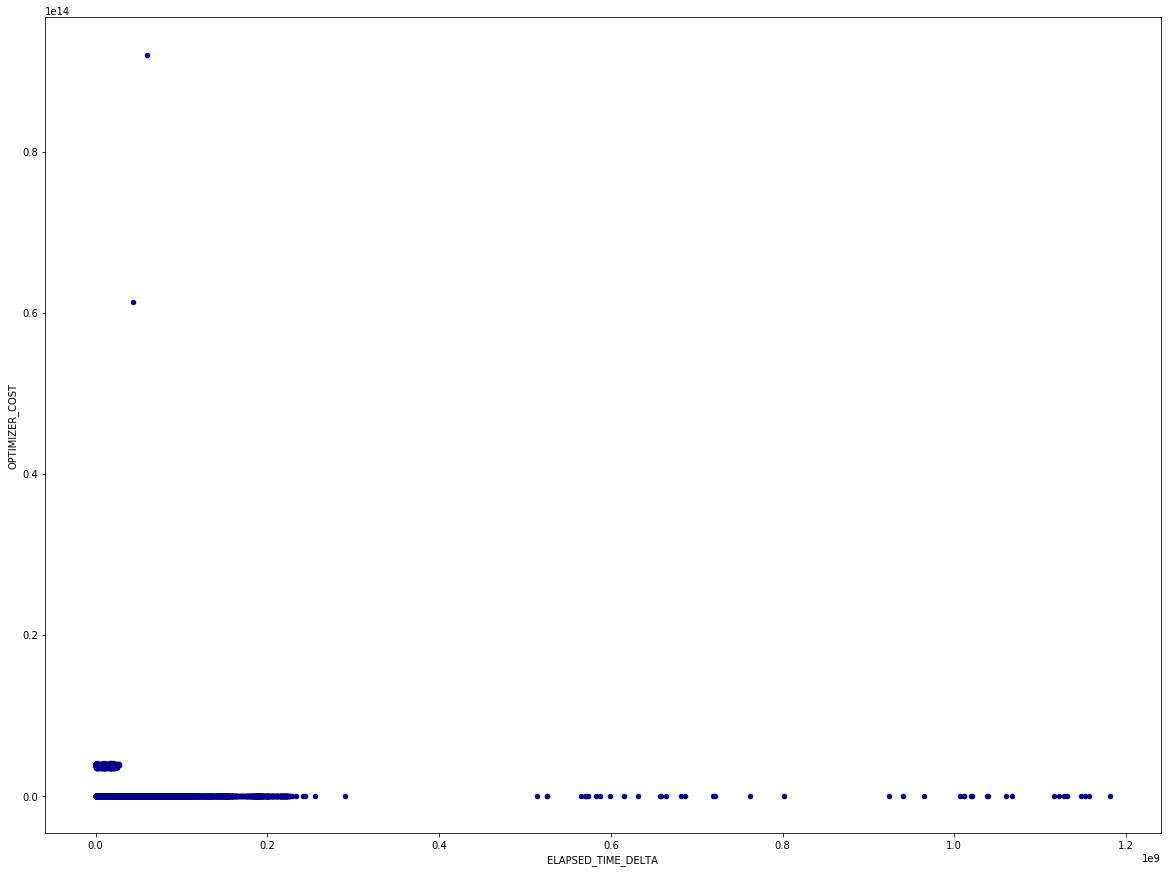

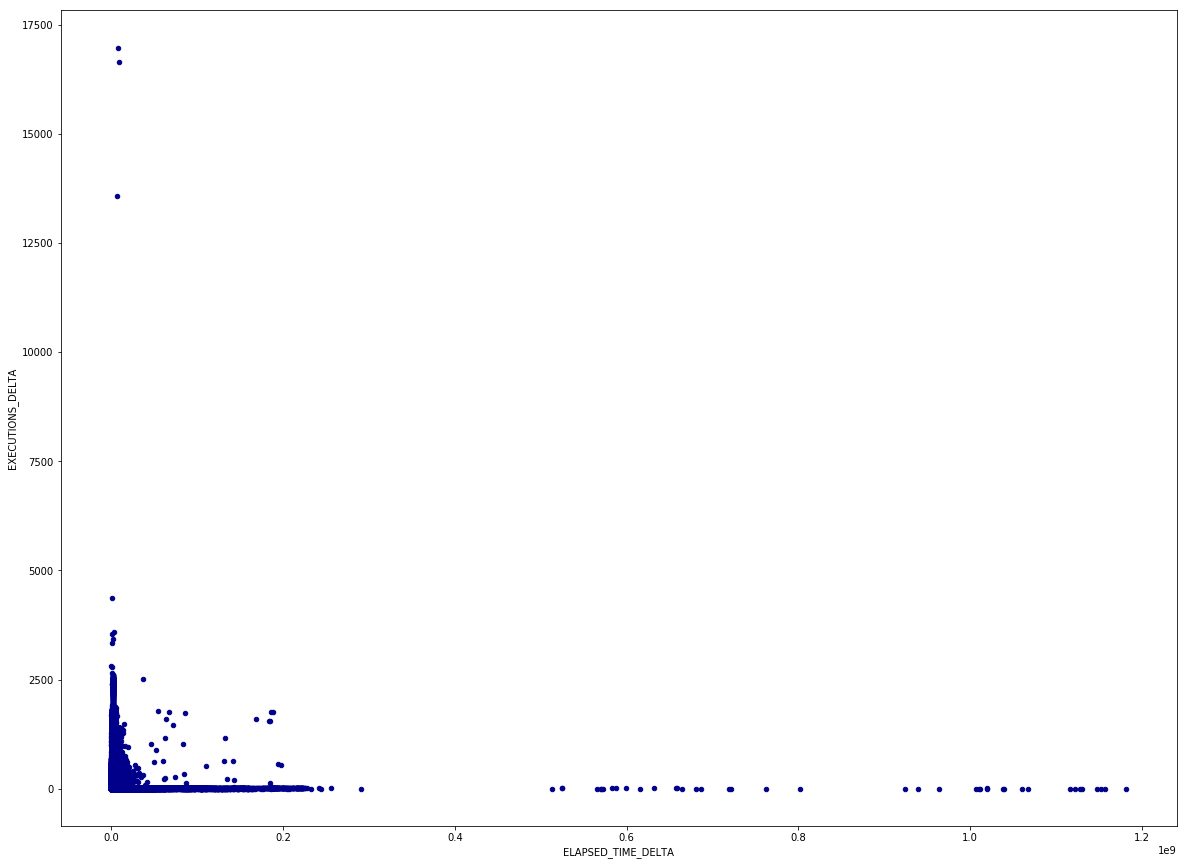

In [109]:
#y_label = ['CPU_TIME_DELTA','OPTIMIZER_COST','EXECUTIONS_DELTA','ELAPSED_TIME_DELTA']
plt.rcParams['figure.figsize'] = [20, 15]
rep_hist_snapshot_df.plot.scatter(x='CPU_TIME_DELTA',
                                  y='OPTIMIZER_COST',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='CPU_TIME_DELTA',
                                  y='EXECUTIONS_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='CPU_TIME_DELTA',
                                  y='ELAPSED_TIME_DELTA',
                                  c='DarkBlue')
plt.show()
print('--------------------------------------------------------')
rep_hist_snapshot_df.plot.scatter(x='OPTIMIZER_COST',
                                  y='CPU_TIME_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='OPTIMIZER_COST',
                                  y='EXECUTIONS_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='OPTIMIZER_COST',
                                  y='ELAPSED_TIME_DELTA',
                                  c='DarkBlue')
plt.show()
print('--------------------------------------------------------')
rep_hist_snapshot_df.plot.scatter(x='EXECUTIONS_DELTA',
                                  y='CPU_TIME_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='EXECUTIONS_DELTA',
                                  y='OPTIMIZER_COST',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='EXECUTIONS_DELTA',
                                  y='ELAPSED_TIME_DELTA',
                                  c='DarkBlue')
plt.show()
print('--------------------------------------------------------')
rep_hist_snapshot_df.plot.scatter(x='ELAPSED_TIME_DELTA',
                                  y='CPU_TIME_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='ELAPSED_TIME_DELTA',
                                  y='OPTIMIZER_COST',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='ELAPSED_TIME_DELTA',
                                  y='EXECUTIONS_DELTA',
                                  c='DarkBlue')
plt.show()

### Box Plots / Outlier Plots

Outlier plots for all targetted labels:

* CPU_TIME_DELTA
* OPTIMIZER_COST
* EXECUTIONS_DELTA
* ELAPSED_TIME_DELTA

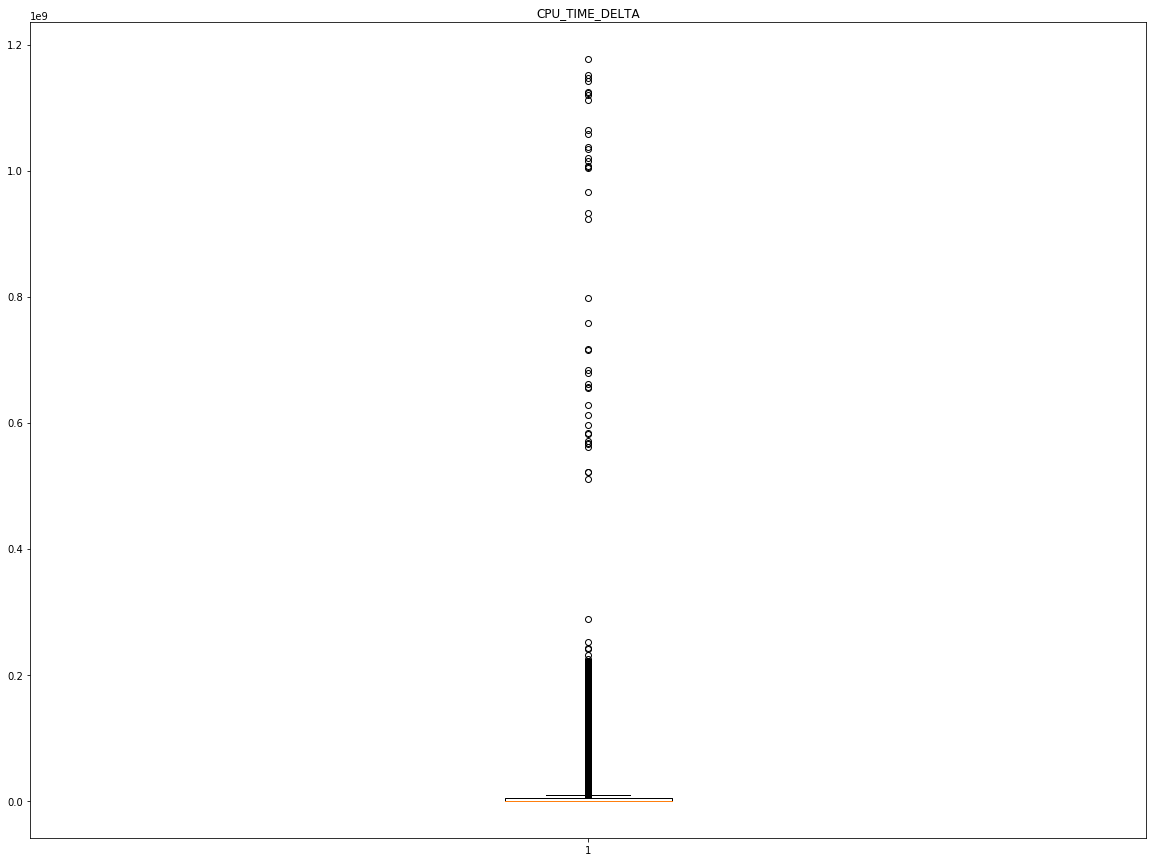

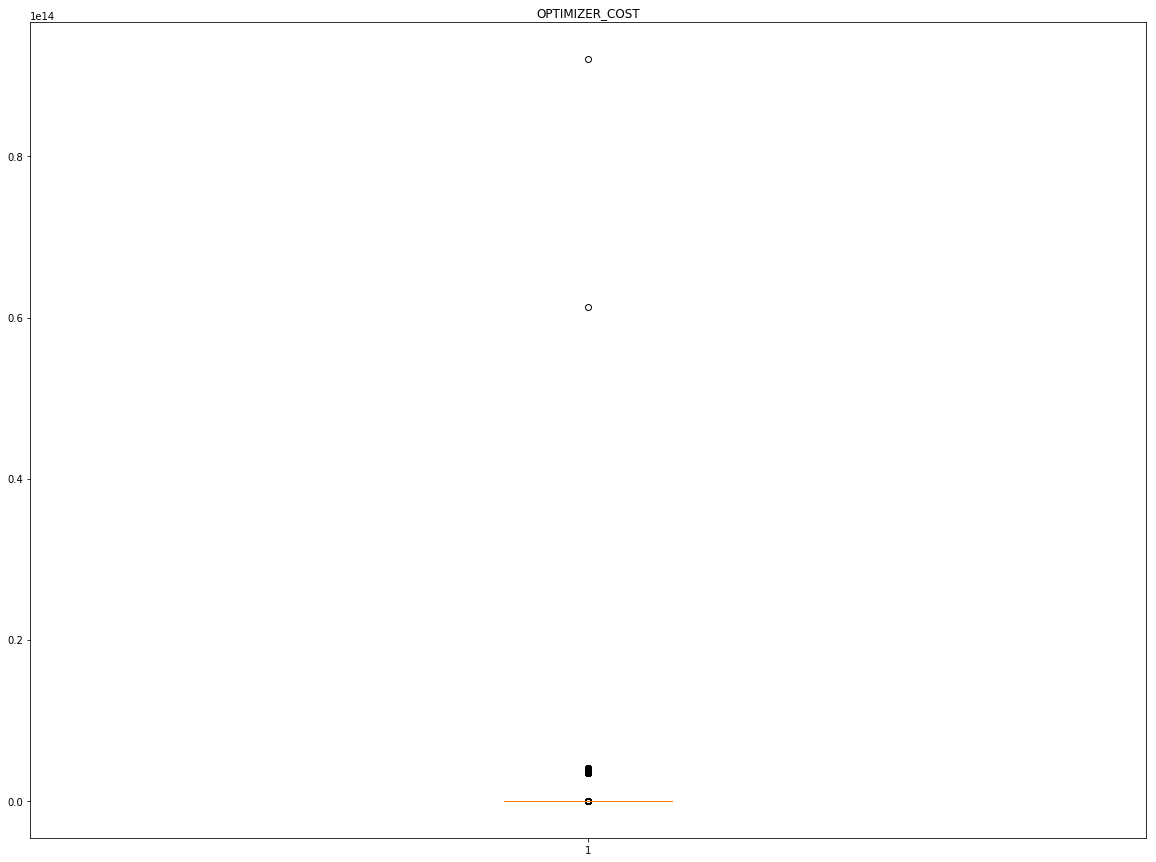

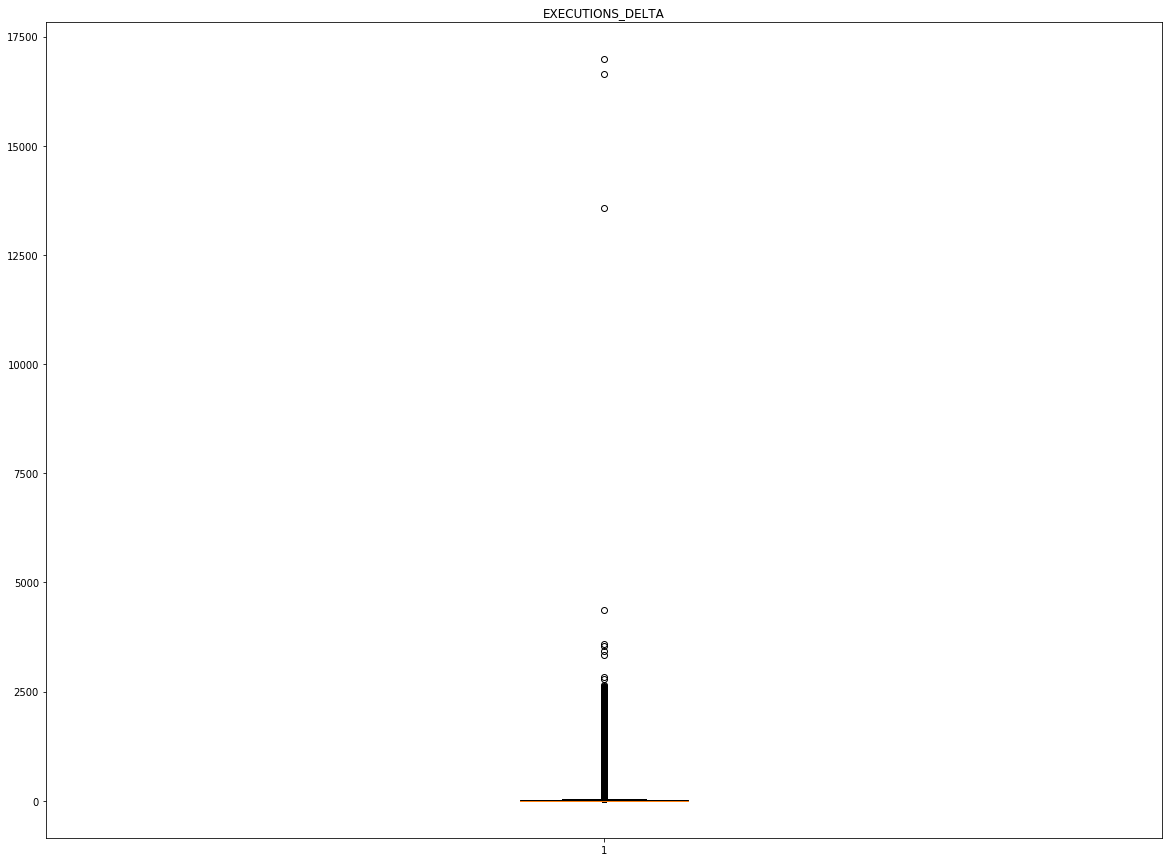

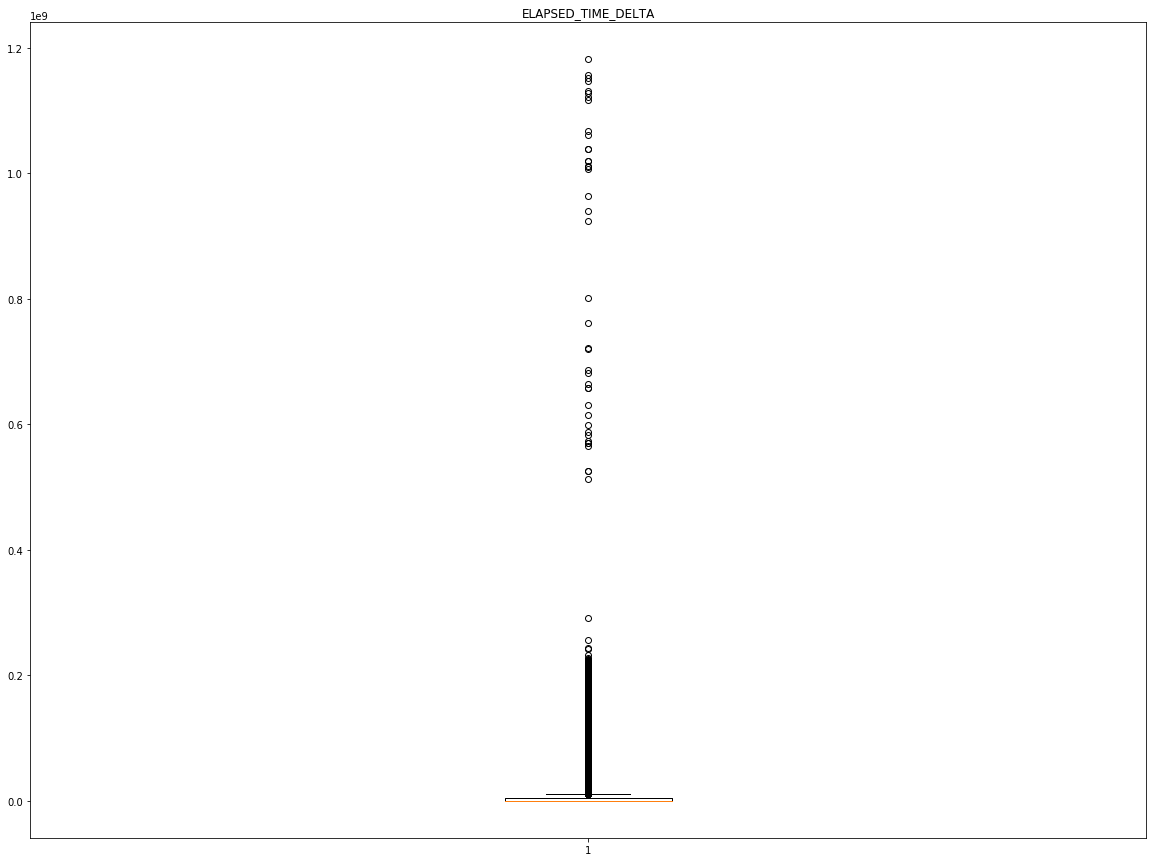

In [110]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.boxplot(rep_hist_snapshot_df['CPU_TIME_DELTA'].values)
plt.title('CPU_TIME_DELTA')
plt.show()
plt.boxplot(rep_hist_snapshot_df['OPTIMIZER_COST'].values)
plt.title('OPTIMIZER_COST')
plt.show()
plt.boxplot(rep_hist_snapshot_df['EXECUTIONS_DELTA'].values)
plt.title('EXECUTIONS_DELTA')
plt.show()
plt.boxplot(rep_hist_snapshot_df['ELAPSED_TIME_DELTA'].values)
plt.title('ELAPSED_TIME_DELTA')
plt.show()

### Top Label Values

This section plots the top hundred values per label, order from highest to lowest. Targetted labels are as follows:

* CPU_TIME_DELTA
* OPTIMIZER_COST
* EXECUTIONS_DELTA
* ELAPSED_TIME_DELTA

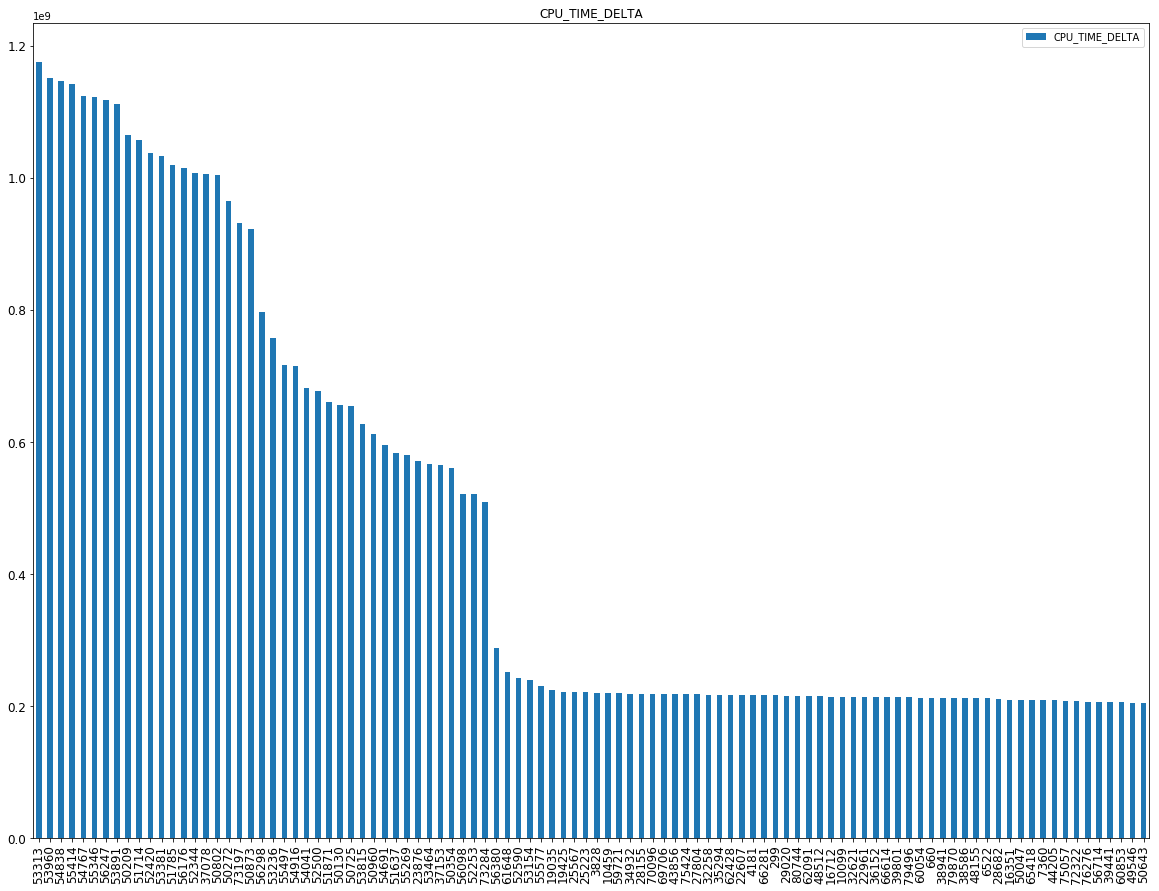

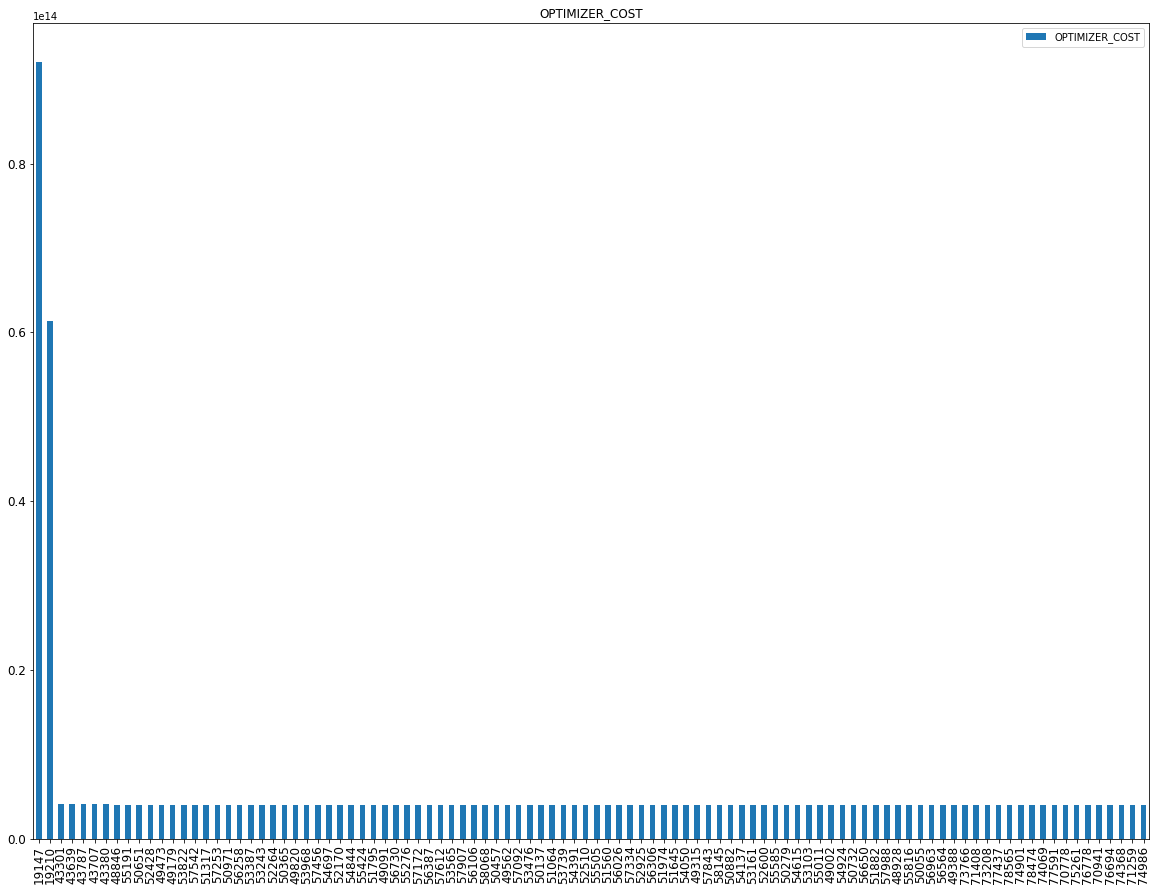

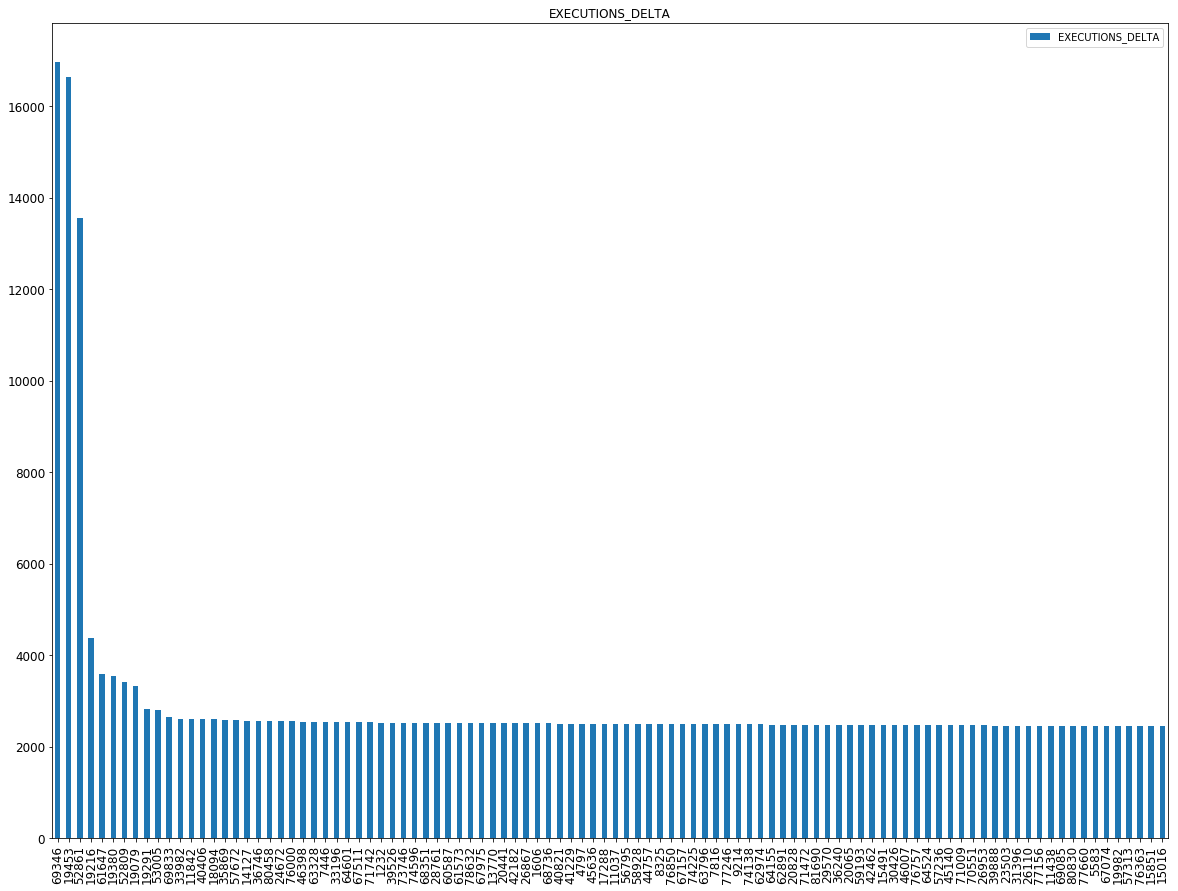

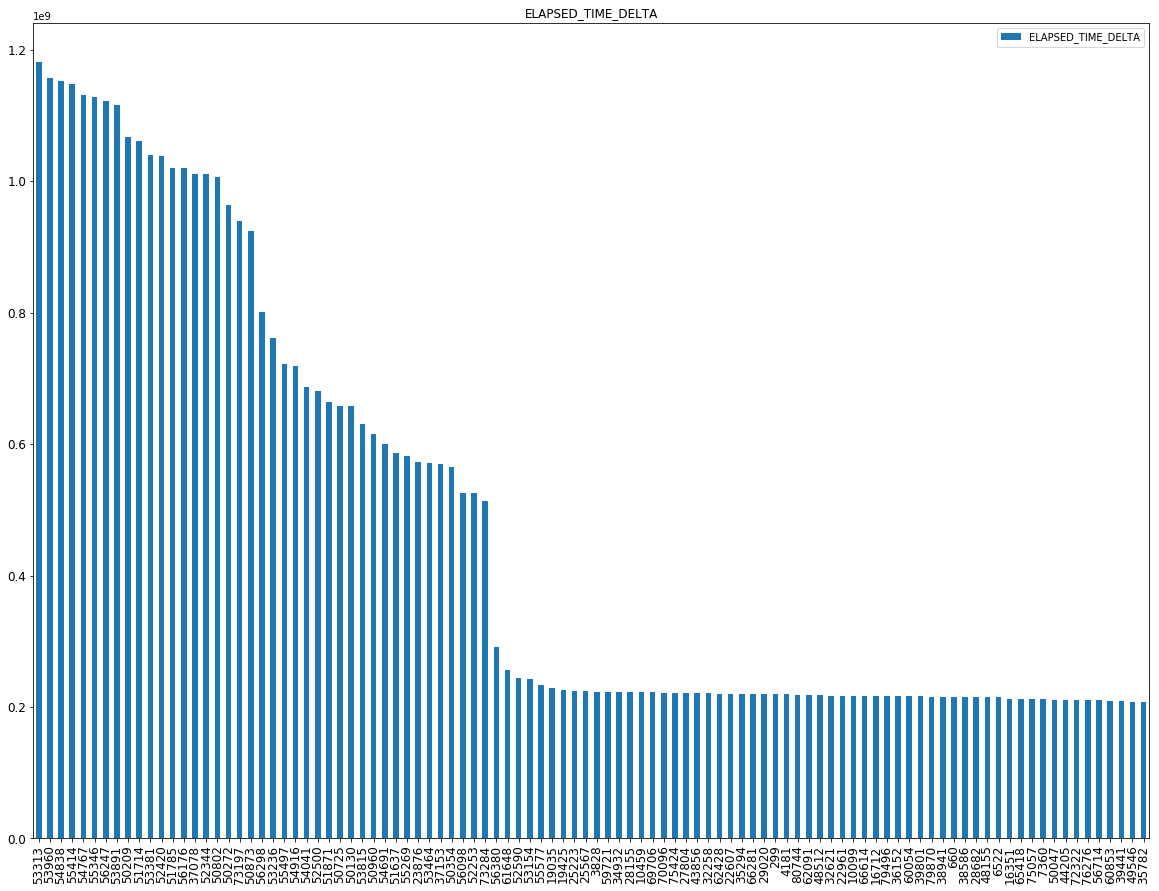

In [111]:
limit = 100
label = 'CPU_TIME_DELTA'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'OPTIMIZER_COST'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'EXECUTIONS_DELTA'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False,)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'ELAPSED_TIME_DELTA'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
plt.show()

## Guaging Outliers (REP_VSQL_PLAN)

Uses the following labels and plots them, so as to showcase the presence of outliers:
* COST
* CARDINALITY
* BYTES
* CPU_COST
* IO_COST
* TEMP_SPACE
* TIME

### Scatter Plots

The following section caters fro scatter plots between all labels as follows:

------------------------------------------
* COST vs CARDINALITY
* COST vs BYTES
* COST vs IO_COST
* COST vs TEMP_SPACE
* COST vs TIME

KeyError: 'BYTES'

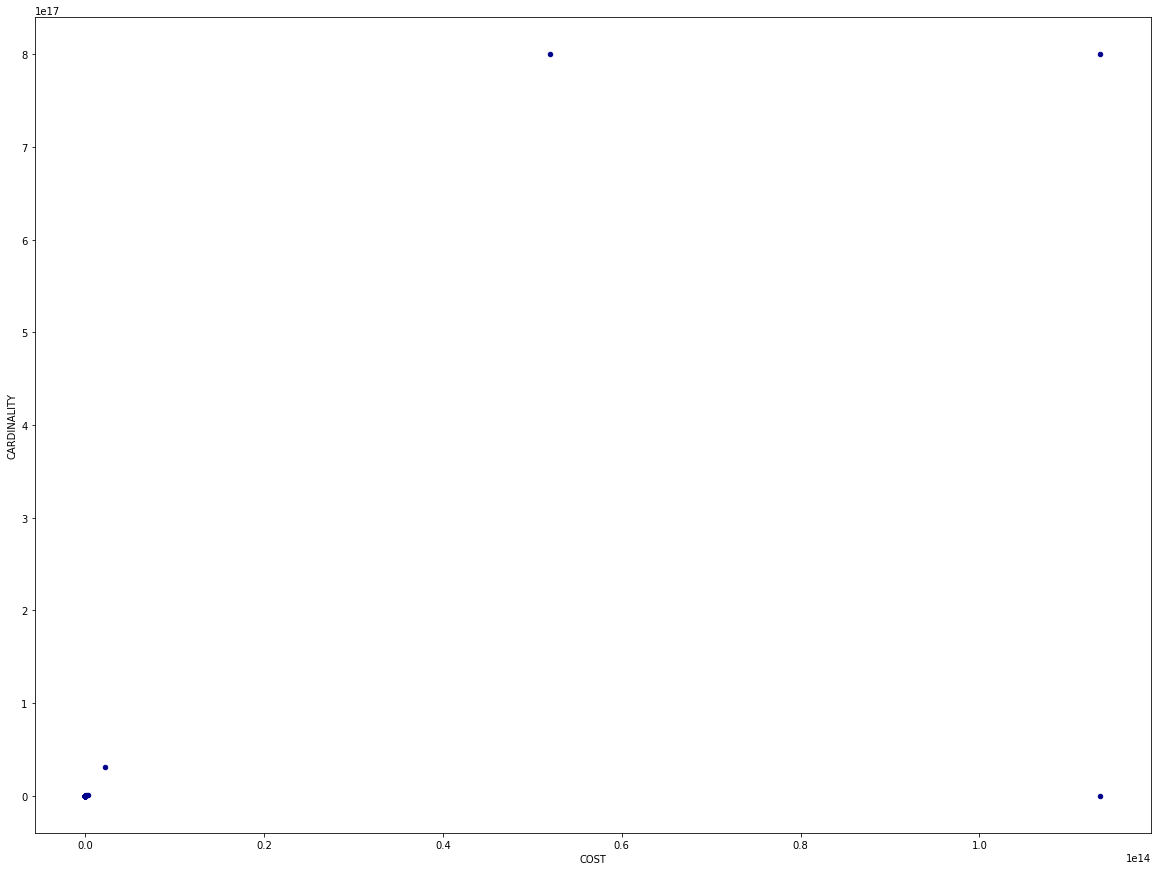

In [112]:
# y_label2 = ['COST','CARDINALITY','BYTES','IO_COST','TEMP_SPACE','TIME']
plt.rcParams['figure.figsize'] = [20, 15]
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='CARDINALITY',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='BYTES',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='IO_COST',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='TEMP_SPACE',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='TIME',
                              c='DarkBlue')
plt.show()

### Box Plots / Outlier Plots

Outlier plots for all targetted labels:

* COST
* CARDINALITY
* BYTES
* IO_COST
* TEMP_SPACE
* TIME

In [ ]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.boxplot(rep_vsql_plan_df['COST'].values)
plt.title('COST')
plt.show()
plt.boxplot(rep_vsql_plan_df['CARDINALITY'].values)
plt.title('CARDINALITY')
plt.show()
plt.boxplot(rep_vsql_plan_df['BYTES'].values)
plt.title('BYTES')
plt.show()
plt.boxplot(rep_vsql_plan_df['IO_COST'].values)
plt.title('IO_COST')
plt.show()
plt.boxplot(rep_vsql_plan_df['TEMP_SPACE'].values)
plt.title('TEMP_SPACE')
plt.show()
plt.boxplot(rep_vsql_plan_df['TIME'].values)
plt.title('TIME')
plt.show()

### Top Label Values

This section plots the top hundred values per label, order from highest to lowest. Targetted labels are as follows:

* COST
* CARDINALITY
* BYTES
* IO_COST
* TEMP_SPACE
* TIME

In [ ]:
limit = 100
label = 'COST'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'CARDINALITY'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'BYTES'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'IO_COST'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'TEMP_SPACE'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'TIME'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
plt.show()

## K-Means Clustering (K=2)

Attempts at clustering data (Separation between inliers and outliers). Initial attempts will target K=2, and then visualize centroid to gauge their effectiveness in the achieved clustering.

### REP_HIST_SNAPSHOT K-Means Application

Applying REP_HIST_SNAPSHOT labels through K-Means (K=2)

In [ ]:
def get_col_pos(df, target_label):
    """
    Iterates over column, and retrieves position of col in dataset
    """
    columns = df.columns
    index = -1
    for i in range(0,len(columns)):
        if columns[i].lower() == target_label.lower():
            index = i
            break
    return index
#
K = 2
kmeans_hist = KMeans(n_clusters=K, random_state=0).fit(rep_hist_snapshot_df.values)
print(kmeans_hist)
print(kmeans_hist.labels_)
unique, counts = np.unique(kmeans_hist.labels_, return_counts=True)
print('Unique: ' + str(unique))
print('Counts: ' + str(counts))
print(kmeans_hist.cluster_centers_)
#
plt.rcParams['figure.figsize'] = [20, 15]
##################################
plt.scatter(x=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'CPU_TIME_DELTA')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'CPU_TIME_DELTA')],
            c='r')
plt.title('ELAPSED_TIME_DELTA vs CPU_TIME_DELTA')
plt.xlabel('ELAPSED_TIME_DELTA')
plt.ylabel('CPU_TIME_DELTA')
plt.show()
##################################
plt.scatter(x=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'OPTIMIZER_COST')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'OPTIMIZER_COST')],
            c='r')
plt.title('ELAPSED_TIME_DELTA vs OPTIMIZER_COST')
plt.xlabel('ELAPSED_TIME_DELTA')
plt.ylabel('OPTIMIZER_COST')
plt.show()
##################################
plt.scatter(x=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'EXECUTIONS_DELTA')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'EXECUTIONS_DELTA')],
            c='r')
plt.title('ELAPSED_TIME_DELTA vs EXECUTIONS_DELTA')
plt.xlabel('ELAPSED_TIME_DELTA')
plt.ylabel('EXECUTIONS_DELTA')
plt.show()

### REP_VSQL_PLAN K-Means Application

Applying REP_VSQL_PLAN labels through K-Means (K=2)

In [ ]:
#
kmeans_vsql = KMeans(n_clusters=K, random_state=0).fit(rep_vsql_plan_df.values)
print(kmeans_vsql)
print(kmeans_vsql.labels_)
unique, counts = np.unique(kmeans_vsql.labels_, return_counts=True)
print('Unique: ' + str(unique))
print('Counts: ' + str(counts))
print(kmeans_vsql.cluster_centers_)
#
plt.rcParams['figure.figsize'] = [20, 15]
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'CARDINALITY')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'CARDINALITY')],
            c='r')
plt.title('COST vs CARDINALITY')
plt.xlabel('COST')
plt.ylabel('CARDINALITY')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'BYTES')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'BYTES')],
            c='r',)
plt.title('COST vs BYTES')
plt.xlabel('COST')
plt.ylabel('BYTES')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'IO_COST')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'IO_COST')],
            c='r')
plt.title('COST vs IO_COST')
plt.xlabel('COST')
plt.ylabel('IO_COST')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'TEMP_SPACE')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'TEMP_SPACE')],
            c='r')
plt.title('COST vs TEMP_SPACE')
plt.xlabel('COST')
plt.ylabel('TEMP_SPACE')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'TIME')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'TIME')],
            c='r')
plt.title('COST vs TIME')
plt.xlabel('COST')
plt.ylabel('TIME')
plt.show()

In [ ]:
for i in range(len(kmeans_hist.labels_)):
    if kmeans_hist.labels_[i] == 0:
        print(rep_hist_snapshot_df.iloc[i])
        break
print('----------------------------------------')
for i in range(len(kmeans_hist.labels_)):
    if kmeans_hist.labels_[i] == 1:
        print(rep_hist_snapshot_df.iloc[i])
        break
print('----------------------------------------')
print('----------------------------------------')
print('----------------------------------------')
for i in range(len(kmeans_vsql.labels_)):
    if kmeans_vsql.labels_[i] == 0:
        print(rep_vsql_plan_df.iloc[i])
        break
print('----------------------------------------')
for i in range(len(kmeans_vsql.labels_)):
    if kmeans_vsql.labels_[i] == 1:
        print(rep_vsql_plan_df.iloc[i])
        break

### Top K-NN Outlier Detection

This section attempts at identifying outliers using Top K-NN

In [ ]:
class TopKNNWrapper:
    #
    def __init__(self, X):
        self.df = X
        self.X = RobustScaler().fit_transform(X.values)
        print(self.X)
    #
    def __get_minimum_vector(self):
        """
        Returns numpy vector, corresponding to smallest possible point in relation to dataset
        """
#         minimal_list = []
#         df = self.df
#         for col in df.columns:
#             minimal_list.append(df[col].min())
#        return np.array(minimal_list)
        return np.amin(self.X, axis=0)
    #
    def get_top_K_outliers(self, topK):
        distance_matrix = [] # [index, distance]
        minimal_vector = self.__get_minimum_vector()
        euc_dist = euclidean_distances(self.X, minimal_vector.reshape(1, -1))
        for i in range(0, len(euc_dist)):
            distance_matrix.append([i, euc_dist[i]])
        distance_matrix = np.array(distance_matrix)
        distance_matrix = distance_matrix[np.argsort(distance_matrix[:, 1])[::-1]]
        outliers = distance_matrix[0:topK]
        print(outliers)
        return outliers
    #
    def plot_outliers(self, topK):
        outliers = self.get_top_K_outliers(topK)
        plt.figure(figsize=(12, 8))
        plt.bar(np.arange(len(outliers[:,1])), outliers[:,1], align='center');
        plt.title('Top KNN Distance From Minimum Vector')
        plt.show()        

In [ ]:
topK = 100
#
# REP_HIST_SNAPSHOT
tkw = TopKNNWrapper(X=rep_hist_snapshot_df)
outliers = tkw.get_top_K_outliers(topK=topK)
tkw.plot_outliers(topK=topK)
#
print('------------------------------------------------------')
#
# REP_VSQL_PLAN
tkw = TopKNNWrapper(X=rep_vsql_plan_df)
outliers = tkw.get_top_K_outliers(topK=topK)
tkw.plot_outliers(topK=topK)

### K-Means Clustering

So as to verify the success of the clustering attempts, the achieved clustering labels require to be compared
to what is assumed to be the actual label predictions. These 'actual' clusters will be assumed to coincide with
the data matrix average - if a particular data vector is larger/smaller than the mean threshold, it will coincide in one cluster or the other.

In [ ]:
class ValidateKMeans:
    """
    Wrapper class for the KMeans algorithm, so as to validate the clustering it has achieved
    """
    #
    def __init__(self, X, k, parallel_degree):
        self.df = X
        self.X = RobustScaler().fit_transform(X.values)
        self.k = k
        self.model = KMeans(n_clusters=self.k, random_state=0, init='k-means++',n_jobs=parallel_degree)
        self.model.fit(self.X)
        self.__y_labels = self.model.labels_
        self.scorings = []
        print(self.model)
    #        
    def __get_threshold_vector(self):
        mean = np.mean(self.X)
        std = np.std(self.X)
        std3 = np.multiply(std, 3)
        return np.add(mean, std3)
    #
    def __calculate_expected_labels(self):
        """
        Estimates label clustering by comparing them to a threshold mean value. These labels
        will be used to gauge a scoring for the unsupervised clustering achieved by the K-Means algorithm.
        """
        thresh_vect = self.__get_threshold_vector()
        mean_labels = []
        for vector in self.X:
            if np.greater(vector, thresh_vect).any():
                mean_labels.append(1)
            else:
                mean_labels.append(0)
        return mean_labels
    #
    def outlier_score_precision(self):
        """
        Returns a score which evaluates the accuracy with the number of isolated outliers. The closer to 0 the score, the more accurate the evaluation
        """
        if self.scorings is None or len(self.scorings) == 0:
            raise ValueError('Scorings list is empty!')
        elif len(self.scorings) > 2:
            raise ValueError('Scorings list length is greater than 2! Must be composed of the following structure [scoring1, scoring2]')
        #
        return math.sqrt((self.scorings[1] - self.scorings[0])**2)
    #
    def label_centroids(self):
        centroids = self.model.cluster_centers_
        mean_vect = self.__get_threshold_vector()
        categorized_labels = [] # [[Self_Classified_Label,Centroid_Label],[Self_Classified_Label,Centroid_Label],...]
        for i in range(len(centroids)):
            if np.greater(centroids[i], mean_vect).any():
                categorized_labels.append([1,i])
            else:
                categorized_labels.append([0,i])
        return categorized_labels
    #
    def evaluate_clusters(self):
        y = self.__calculate_expected_labels()
        yhat = []
        labelled_centroids = self.label_centroids()
        print('Labeled Centroids: ' + str(labelled_centroids))
        #
        for label in self.__y_labels:
            for x, i in labelled_centroids:
                if label == i:
                    yhat.append(x)
                    break
        #
        print('Total Clusters [' + str(self.k) + ']\nDistribution:')
        unique, counts = np.unique(y, return_counts=True)
        print('Expected Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
            if unique[i] == 1:
                self.scorings.append(counts[i])
        unique, counts = np.unique(yhat, return_counts=True)
        print('Clustered Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
            if unique[i] == 1:
                self.scorings.append(counts[i])
        #
        print("\n----\nAccuracy: " + str(accuracy_score(y, yhat)))
        print("Precision: " + str(precision_score(y, yhat, average='micro')))
        print("Recall: " + str(recall_score(y, yhat, average='micro')))
        print("F-Score: " + str(f1_score(y, yhat, average='micro')))
        print("Outlier Score Precision [" + str(self.outlier_score_precision()) + "]\n----")
        #
        fpr_RF, tpr_RF, thresholds_RF = roc_curve(y, yhat)
        auc_RF = roc_auc_score(y, yhat)
        print('AUC RF:%.3f'% auc_RF)
        plt.plot(fpr_RF, tpr_RF,'r-',label = 'RF AUC: %.3f'%auc_RF)
        plt.plot([0,1],[0,1],'k-',label='random')
        plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
        plt.legend()
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

### Exhausting K

Iterating over a number of K values, whilst gauging K under different number of combinations. Each K denotes the number of clusters as to group the data with. In turn, each cluster is then further categorized into 2 groups, those pertaining to:
* Inliers
* Outliers

Accuracy, Precision, Recall & FScore metrics will be used to evaluate the effectiveness of each K-Means choice, with each experiment executed 3 times to anticipate for random variants of centroid positioning (Initial positioning is handled by K-Means++). Clustered amounts will be compared to a rough, hard placed metric, which determines any points to be outliers if they contain a data point at the 99th % standard deviation.

An additional metric (apart from those mentioned above) will be used during the evaluation of this experiment. Particular focus will be given to the number of clustered outlier points, discounting inliers all together. The score fluctuates at 0 < x < 2 , where in a score of 0 denotes perfect accuracy.

In [ ]:
def exhaust_k_possibilities(df):
    """
    Method which attempts to exhaust a number of K options for the input pandas dataframe.
    K Attempts will be attempted in steps of 2, so as to speed up the K finding process.

    :param - df (Dataframe of type Pandas)
    """
    k_experiment_scorings = [] # k, score
    for k in range(2, len(df.columns), 2):
        print('Experiment start -------------[' + str(k) + ']-------------')
        experiment_scorings = []
        for i in range(3):
            validInstance = ValidateKMeans(df, k, parallel_degree)
            validInstance.evaluate_clusters()
            experiment_scorings.append(validInstance.outlier_score_precision())
        k_experiment_scorings.append([k, sum(experiment_scorings)/len(experiment_scorings)])
        print('Experiment end -------------[' + str(k) + ']-------------')
    #
    final_score, final_k = 3,0
    for k,score in k_experiment_scorings:
        if score < final_score:
            if score < 1:
                score = 1-score
            else:
                score = score-1
            final_k = k
            final_score = score # The closer score is to 0, the more accuracte the number of clustered outliers
    print('\n\nExperiment Conclusion: K[' + str(final_k) + '] - score[' + str(final_score) + ']')
#
print('Experiment: REP_HIST_SNAPSHOT K-MEANS GRID SEARCH')
exhaust_k_possibilities(df=rep_hist_snapshot_df)
print('Experiment: REP_VSQL_PLAN K-MEANS GRID SEARCH')
exhaust_k_possibilities(df=rep_vsql_plan_df)

### Isolation Forest Outlier Detection

This section moves past K-Means clustering prediction, and attempts to detect / flag outliers using the Isolation Forest ensemble algorithm.

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [ ]:
class IsolationForestWrapper:
    #
    def __init__(self, X, contamination=.1, parallel_degree=1):
        """
        Constructor Method
        :param X - Pandas Dataframe
        :param contamination - Real value
        :param parallel_degree - Parellization parameter 
        """
        self.X = X.values
        self.model = IsolationForest(n_estimators=100, max_samples=256, contamination=contamination, random_state=0, n_jobs=parallel_degree)
        self.model.fit(self.X)
        self.scorings = []
        print(self.model)
    #    
    def __get_threshold_vector(self):
        mean = np.mean(self.X)
        std = np.std(self.X)
        std3 = np.multiply(std, 3)
        return np.add(mean, std3)
    #
    def __calculate_expected_labels(self):
        """
        Estimates label clustering by comparing them to a threshold mean value. These labels
        will be used to gauge a scoring for the unsupervised clustering achieved by the K-Means algorithm.
        """
        mean_vect = self.__get_threshold_vector()
        mean_labels = []
        for vector in self.X:
            if np.greater(vector, mean_vect).any():
                mean_labels.append(-1)
            else:
                mean_labels.append(1)
        return mean_labels
    #
    def retrieve_scorings(self):
        return self.model.decision_function(self.X)
    #
    def plot_scorings(self):
        """
        Distributes into 50 bin histogram
        """
        scores = self.retrieve_scorings()
        plt.figure(figsize=(12, 8))
        plt.hist(scores, bins=50);
        plt.title('Isolation Forest Scorings')
        plt.show()
    #
    def predict_labels(self):
        return self.model.predict(self.X) 
    #
    def outlier_score_precision(self):
        """
        Returns a score which evaluates the accuracy with the number of isolated outliers. The closer to 0 the score, the more accurate the evaluation
        """
        if self.scorings is None or len(self.scorings) == 0:
            raise ValueError('Scorings list is empty!')
        elif len(self.scorings) > 2:
            raise ValueError('Scorings list length is greater than 2! Must be composed of the following structure [scoring1, scoring2]')
        #
        return math.sqrt((self.scorings[1] - self.scorings[0])**2)
    #
    def evaluate_labels(self):
        y = self.__calculate_expected_labels()
        yhat = self.predict_labels()
        #
        unique, counts = np.unique(y, return_counts=True)
        print('Expected Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
            if unique[i] == -1:
                self.scorings.append(counts[i])
        unique, counts = np.unique(yhat, return_counts=True)
        print('Isolated Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
            if unique[i] == -1:
                self.scorings.append(counts[i])
        #
        print("\n----\nAccuracy: " + str(accuracy_score(y, yhat)))
        print("Precision: " + str(precision_score(y, yhat, average='binary')))
        print("Recall: " + str(recall_score(y, yhat, average='binary')))
        print("F-Score: " + str(f1_score(y, yhat, average='binary')))
        print("Outlier Score Precision [" + str(self.outlier_score_precision()) + "]\n----")
        #
        fpr_RF, tpr_RF, thresholds_RF = roc_curve(y, yhat)
        print(fpr_RF)
        print(tpr_RF)
        auc_RF = roc_auc_score(y, yhat)
        print('AUC RF:%.3f'% auc_RF)
        plt.plot(fpr_RF, tpr_RF,'r-',label = 'RF AUC: %.3f'%auc_RF)
        plt.plot([0,1],[0,1],'k-',label='random')
        plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
        plt.legend()
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

In [ ]:
def exhaust_contamination_possibilities(df):
    """
    Method which attempts to exhaust a number of contamination options for the input pandas dataframe.
    A number of attempts will be attempted so to evaluate the best contamination value.

    :param - df (Dataframe of type Pandas)
    """
    k_experiment_scorings = [] # k, score
    for c in range(.2, 2, .2):
        print('Experiment start -------------[' + str(c) + ']-------------')
        experiment_scorings = []
        for i in range(3):
            ifw = IsolationForestWrapper(X=df, contamination=c, parallel_degree=parallel_degree)
            ifw.plot_scorings()
            ifw.evaluate_labels()
            experiment_scorings.append(ifw.outlier_score_precision())
        k_experiment_scorings.append([k, sum(experiment_scorings)/len(experiment_scorings)])
        print('Experiment end -------------[' + str(k) + ']-------------')
    #
    final_score, final_c = 3,0
    for c,score in k_experiment_scorings:
        if score < final_score:
            if score < 1:
                score = 1-score
            else:
                score = score-1
            final_c = c
            final_score = score # The closer score is to 0, the more accuracte the number of isolated outliers
    print('\n\nExperiment Conclusion: C[' + str(final_c) + '] - score[' + str(final_score) + ']')
#
# REP_HIST_SNAPSHOT
print('Experiment: REP_HIST_SNAPSHOT CONTAMINATION GRID SEARCH')
exhaust_contamination_possibilities(df=rep_hist_snapshot_df)
#
# REP_VSQL_PLAN
print('Experiment: REP_VSQL_PLAN CONTAMINATION GRID SEARCH')
exhaust_contamination_possibilities(df=rep_vsql_plan_df)

### To investigate further

* One Class SVM